In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

``Data loading``

In [3]:
df_arrivals = pd.read_csv('../data/df_arrivals.csv')
df_departures = pd.read_csv('../data/df_departures.csv')
df_low_cost = pd.read_csv('../data/Low_Cost_Airlines.csv')
df_international_airports = pd.read_csv("../data/List_of_international_airports_by_country.csv")


plt.style.use("ggplot")

In [4]:
df_arrivals.shape, df_departures.shape, df_low_cost.shape

((77577, 20), (77577, 20), (179, 1))

In [5]:
def get_nan_rows(df):
    null_df = [df[df[column].isna()] for column in df.columns]
    stats_df = [(column, df[column].isna().sum(), (df[column].isna().sum() / df.shape[0]) * 100) for column in df.columns]
    stats_df = pd.DataFrame(stats_df, columns=["column", "nan_count", "nan_percentage"])
    return null_df, stats_df


def plot_nan_percentage_camembert(df, title):
    _, stats_df = get_nan_rows(df)
    plt.figure(figsize=(20, 10))
    plt.pie(stats_df["nan_percentage"], labels=stats_df["column"], autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(title)
    plt.show()

    return stats_df

def plot_nan_percentage(df, title):
    _, stats_df = get_nan_rows(df)
    plt.figure(figsize=(20, 10))
    sns.barplot(x="nan_percentage", y="column", data=stats_df, orient="h")
    plt.title(title)
    plt.show()

    return stats_df

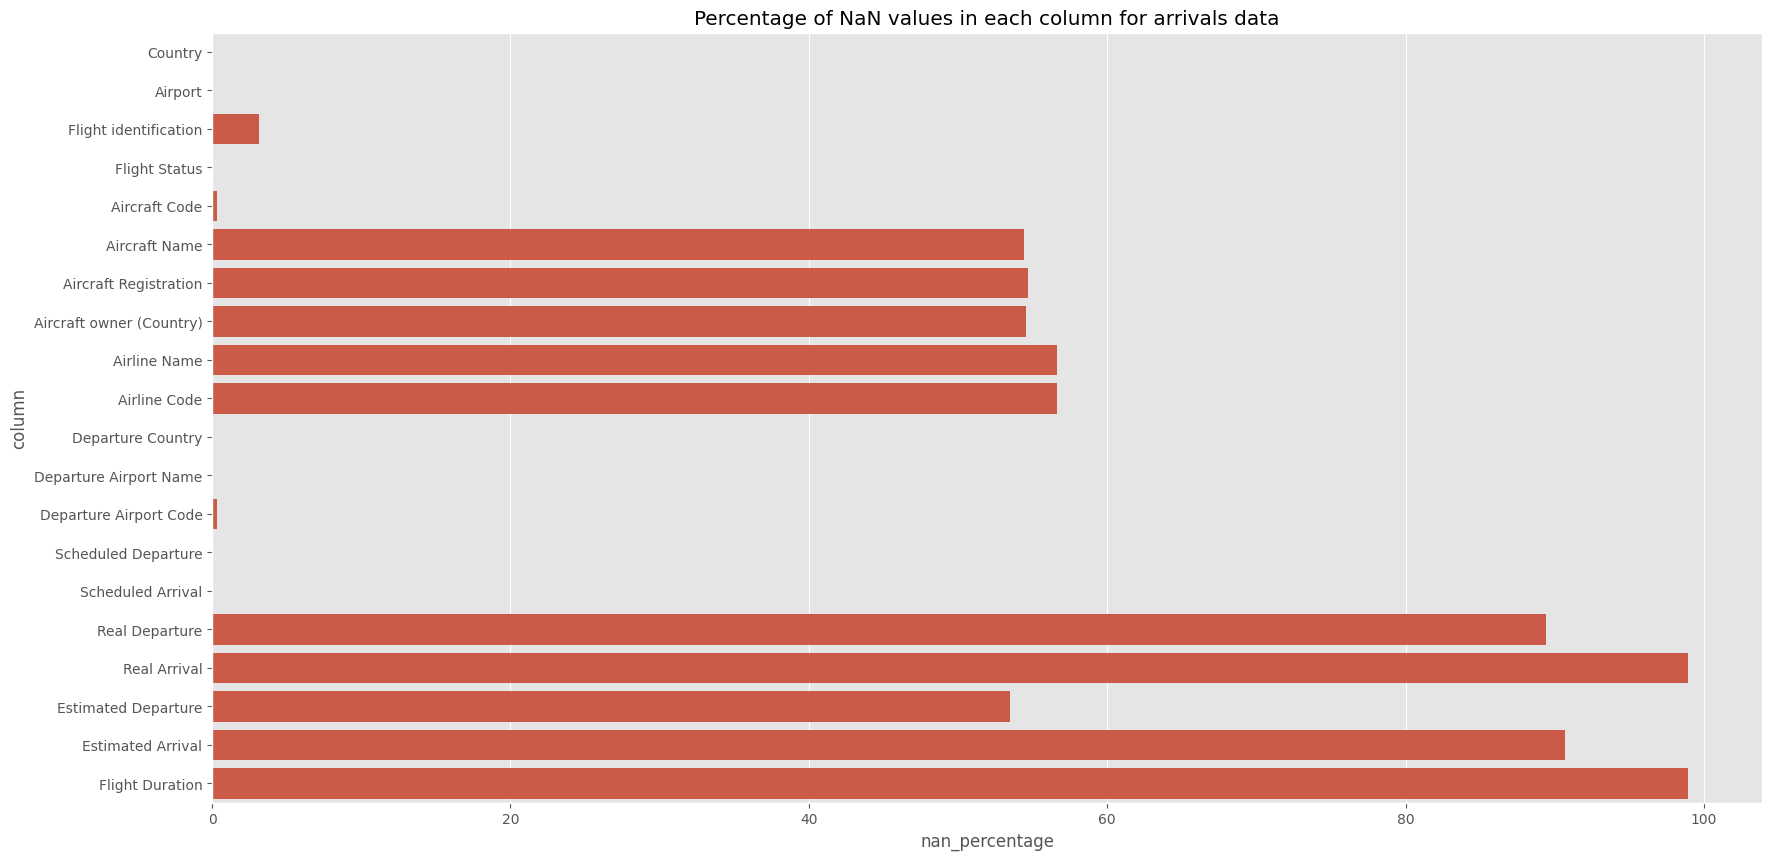

In [6]:
stats_df_arr = plot_nan_percentage(df_arrivals, "Percentage of NaN values in each column for arrivals data")

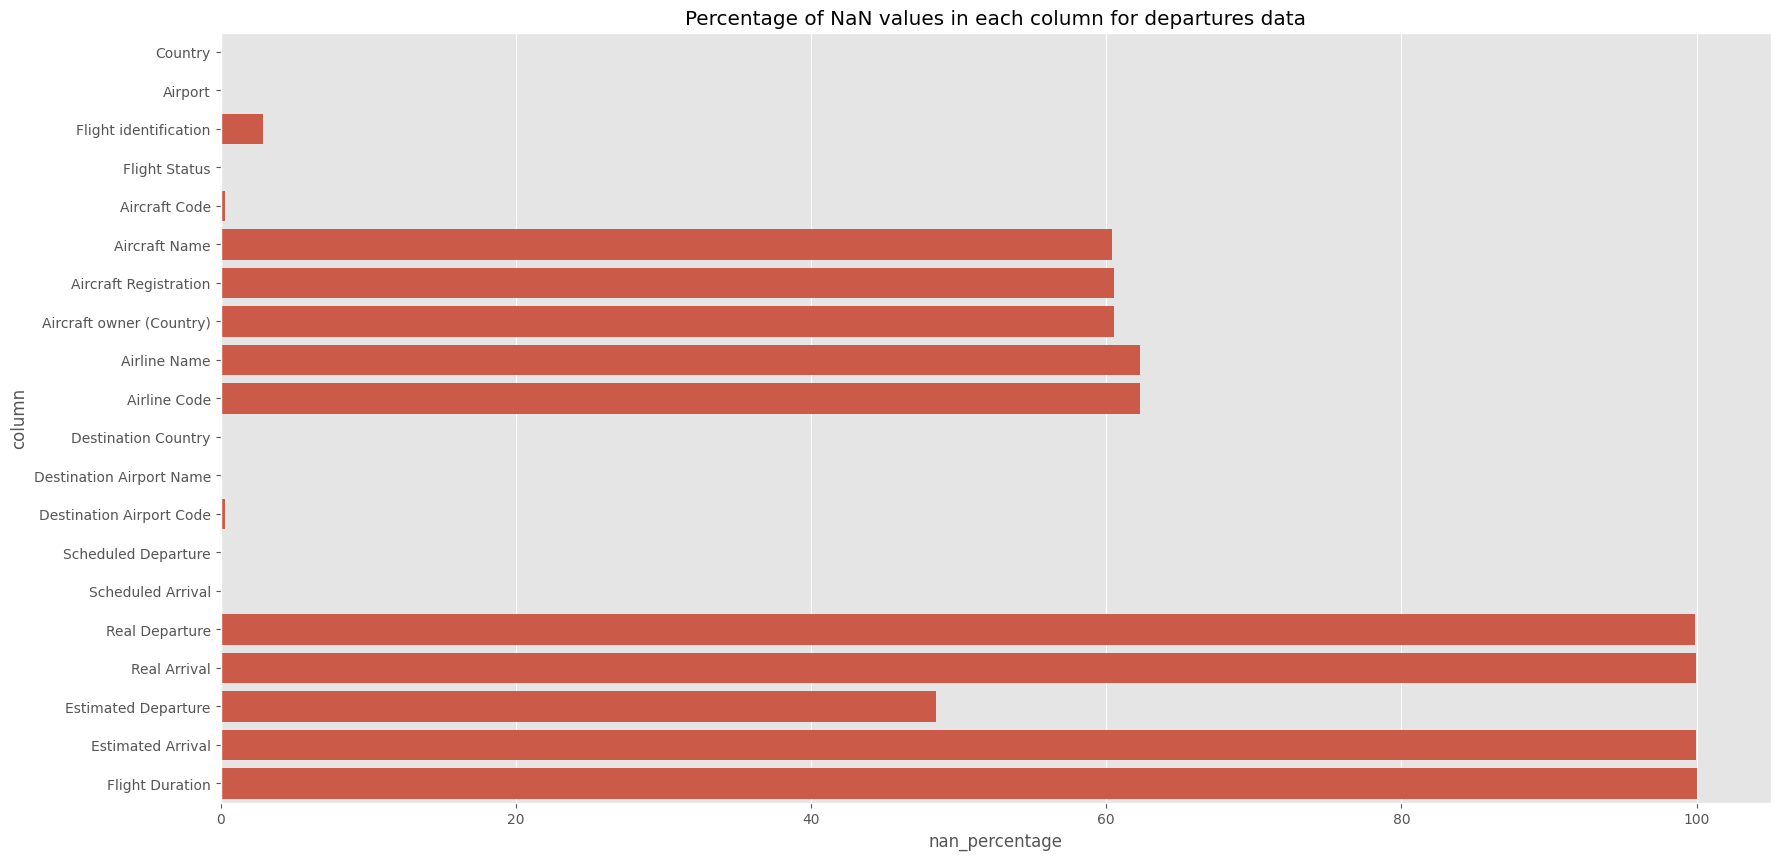

In [7]:
stats_df_dep = plot_nan_percentage(df_departures, "Percentage of NaN values in each column for departures data")

``Data cleaning``
- Nous allons retirer les colonnes avec beaucoup de valeurs manque + de 60%

In [8]:
df_arrivals_cleaned = df_arrivals[pd.notna(df_arrivals["Airline Name"])]
df_departures_cleaned = df_departures[pd.notna(df_departures["Airline Name"])]

df_arrivals_cleaned.shape, df_departures_cleaned.shape, df_low_cost.shape

((33643, 20), (29259, 20), (179, 1))

In [9]:
columns_to_drop = stats_df_arr[stats_df_arr["nan_percentage"] > 60]["column"].values
df_arrivals_cleaned = df_arrivals_cleaned.drop(columns=columns_to_drop)

In [10]:
columns_to_drop = stats_df_dep[stats_df_dep["nan_percentage"] > 65]["column"].values
df_departures_cleaned = df_departures_cleaned.drop(columns=columns_to_drop)

``Data seperation between low-cost and high-cost company``
- On récupère les companies low-cost et fullservice séparemment

In [11]:
def separate_df(df):
    df_low_cost_service = df[df["Airline Name"].isin(df_low_cost["Low Cost Airlines"])]
    df_full_service = df[~df["Airline Name"].isin(df_low_cost["Low Cost Airlines"])]
    return df_low_cost_service, df_full_service

df_arrivals_low_cost, df_arrivals_full_service = separate_df(df_arrivals_cleaned)
df_departures_low_cost, df_departures_full_service = separate_df(df_departures_cleaned)

In [12]:
df_arrivals_low_cost.shape, df_arrivals_full_service.shape, df_departures_low_cost.shape, df_departures_full_service.shape

((8034, 16), (25609, 16), (7444, 16), (21815, 16))

- On vérifie aussi la répartition des valeurs manquantes

<Axes: title={'center': 'Number of NaN values per column for low cost airlines arrivals data'}>

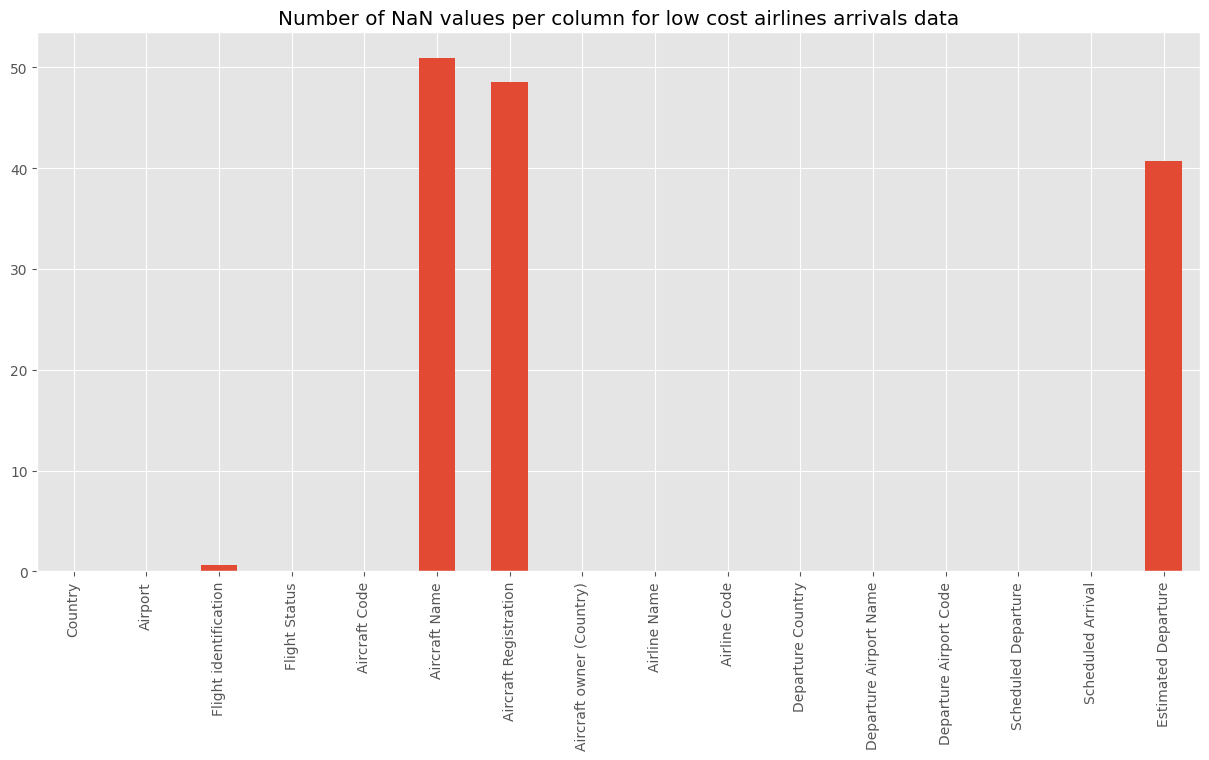

In [13]:
def convert_to_percentage(x):
    return (x / df_arrivals_low_cost.shape[0]) * 100

df_arrivals_low_cost.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for low cost airlines arrivals data")

<Axes: title={'center': 'Number of NaN values per column for high cost airlines arrivals data'}>

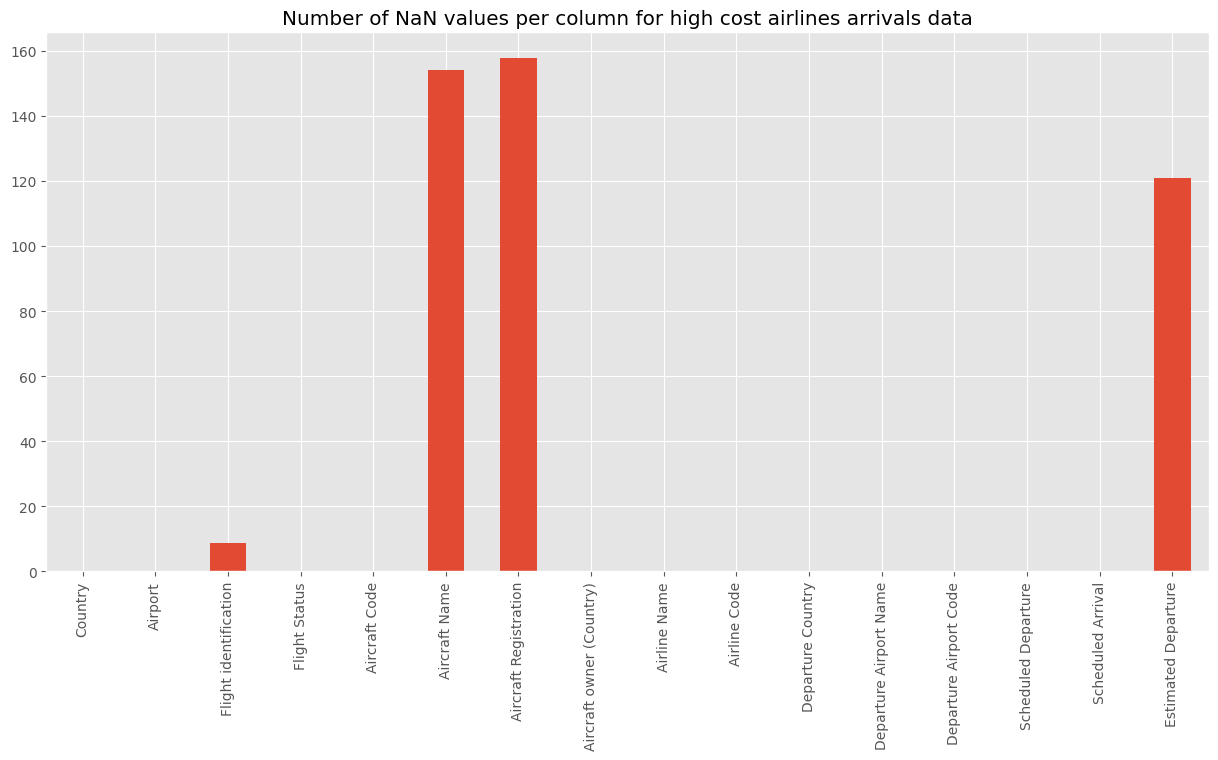

In [14]:
df_arrivals_full_service.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for high cost airlines arrivals data")

<Axes: title={'center': 'Number of NaN values per column for low cost airlines departures data'}>

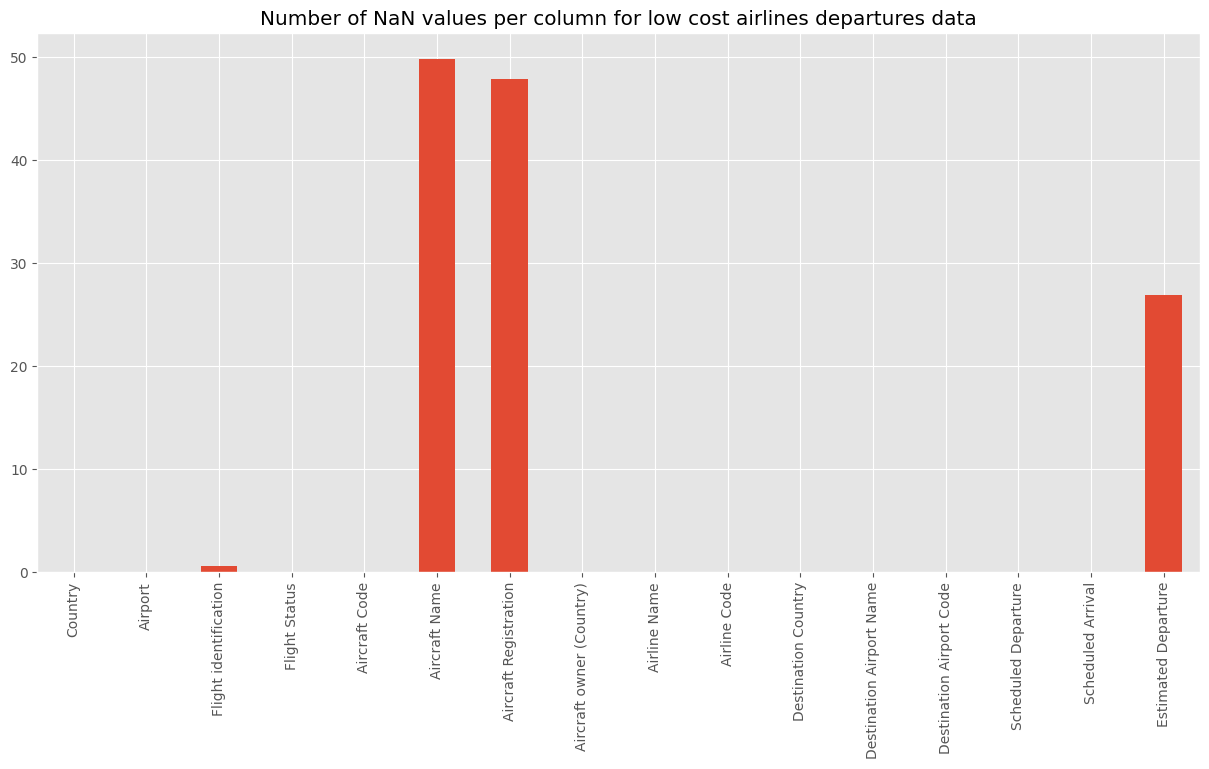

In [15]:
df_departures_low_cost.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column for low cost airlines departures data")

<Axes: title={'center': 'Number of NaN values per column high low cost airlines departures data'}>

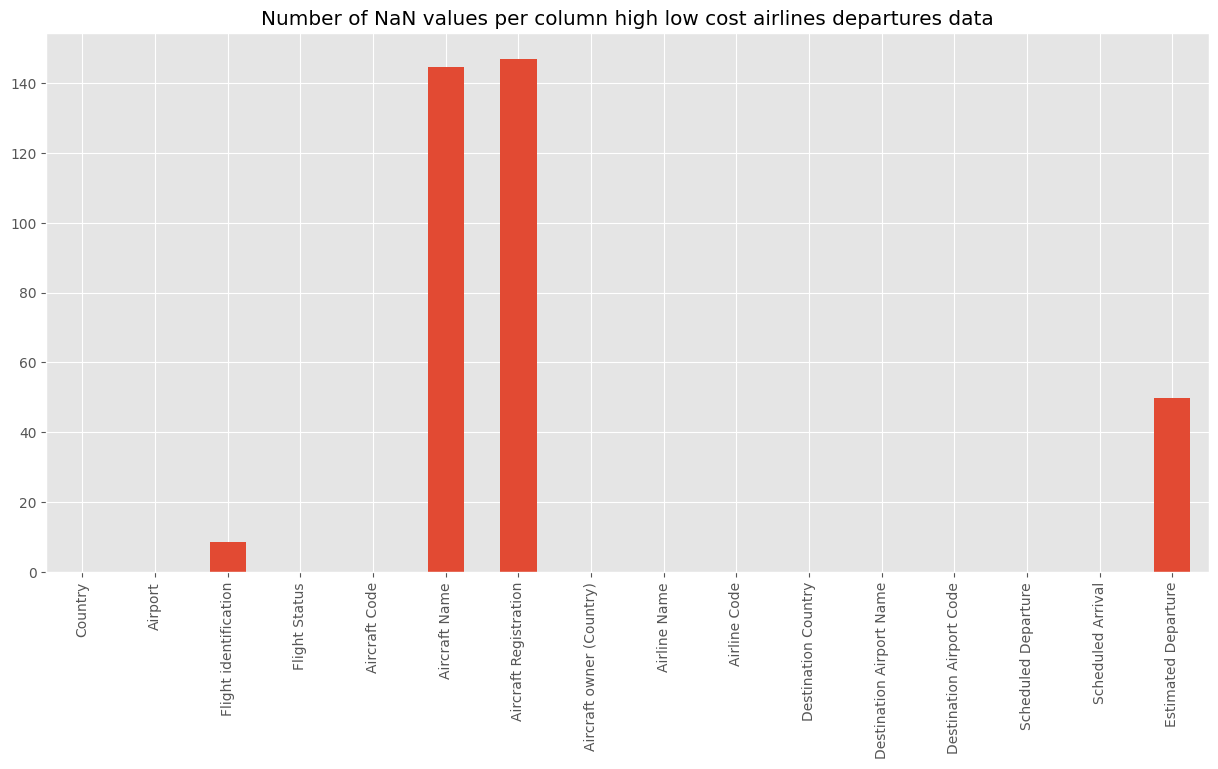

In [16]:
df_departures_full_service.isna().sum().apply(convert_to_percentage).plot(kind="bar", figsize=(15, 7), title="Number of NaN values per column high low cost airlines departures data")

``Number of low cost company vs full service`` 
- On constate clairement que en générale on a bien plus de companies full-service que low-cost (3x +)

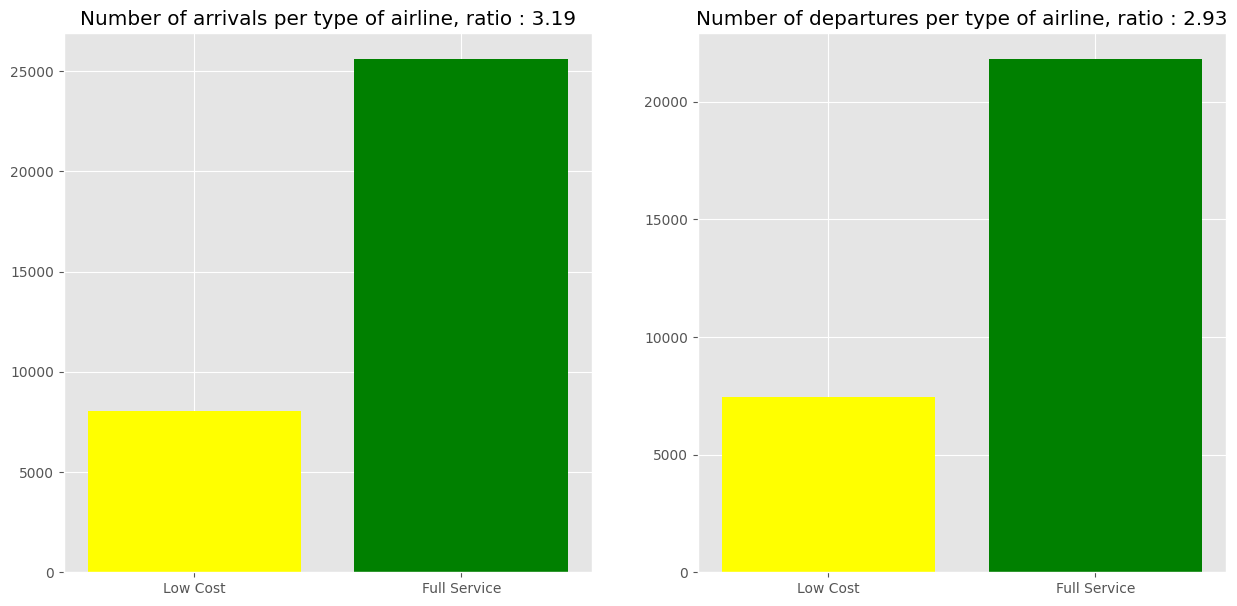

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.bar(["Low Cost", "Full Service"], [df_arrivals_low_cost.shape[0], df_arrivals_full_service.shape[0]], color=["yellow", "green"])
plt.title(f"Number of arrivals per type of airline, ratio : {df_arrivals_full_service.shape[0] / df_arrivals_low_cost.shape[0]:.2f}")
plt.subplot(1, 2, 2)
plt.bar(["Low Cost", "Full Service"], [df_departures_low_cost.shape[0], df_departures_full_service.shape[0]], color=["yellow", "green"])
plt.title(f"Number of departures per type of airline, ratio : {df_departures_full_service.shape[0] / df_departures_low_cost.shape[0]:.2f}")
plt.show()

``Type of plane``
- Pour celà nous allons d'abord join les datasets sur l'attribut d'index pour pouvoir bien comparer

In [18]:
def join_dataset(df_arrivals, df_departures):
    df_matched = df_arrivals.join(df_departures, how='inner', lsuffix='_arr', rsuffix='_dep')
    columns_to_drop = [col for col in df_matched.columns if col.endswith('_dep') and col[:-4] + '_arr' in df_matched.columns]
    df_matched.drop(columns=columns_to_drop, inplace=True)
    df_matched.rename(columns=lambda x: x.replace('_arr', ''), inplace=True)
    return df_matched

df_matched_low_cost = join_dataset(df_arrivals_low_cost, df_departures_low_cost)
df_matched_full_service = join_dataset(df_arrivals_full_service, df_departures_full_service)

df_matched_low_cost.shape, df_matched_full_service.shape

((3137, 19), (13745, 19))

In [19]:
df_matched_low_cost.to_csv("../temp/df_matched_low_cost.csv", index=False)
df_matched_full_service.to_csv("../temp/df_matched_full_service.csv", index=False)


In [20]:
aircraft_low_cost = df_matched_low_cost.groupby("Aircraft Code").apply(len).sort_values(ascending=False)
aircraft_full_service = df_matched_full_service.groupby("Aircraft Code").apply(len).sort_values(ascending=False)

- Tout les codes d'avions

In [21]:
all_aircraf_code = list(set(df_arrivals["Aircraft Code"].unique()).union(df_departures["Aircraft Code"].unique()))

In [22]:
aircraft_low_cost_complete = aircraft_low_cost.reindex(all_aircraf_code, fill_value=0)
aircraft_full_service_complete = aircraft_full_service.reindex(all_aircraf_code, fill_value=0)
combined_aircraft_usage = pd.concat([aircraft_low_cost_complete, aircraft_full_service_complete], axis=1, keys=['Low Cost', 'Full Service'])

In [23]:
df_matched_low_cost.groupby("Aircraft Code")["Airline Name"].describe()

,count,unique,top,freq
Aircraft Code,,,,
A20N,515,10,IndiGo,343
A21N,224,18,IndiGo,146
A319,109,9,Allegiant Air,33
A320,643,18,AirAsia,101
A321,48,9,JetBlue Airways,14
A333,3,2,AirAsia X,2
A359,1,1,French Bee,1
A35K,1,1,French Bee,1
AT75,1,1,Firefly,1


In [24]:
df_matched_full_service.groupby("Aircraft Code")["Airline Name"].describe()

,count,unique,top,freq
Aircraft Code,,,,
A139,3,2,Offshore Helicopter Services,2
A20N,736,57,Azul Linhas Aereas,196
A21N,391,48,Wizz Air Malta,63
A306,28,5,European Air Transport,16
A310,2,1,ULS Airlines Cargo,2
...,...,...,...,...
SB20,2,1,Nyxair,2
SF34,96,8,Rex,49
SU95,15,4,Rossiya,9


In [25]:
combined_aircraft_usage.sort_values(by="Low Cost", ascending=False)

,Low Cost,Full Service
Aircraft Code,,
A320,643,1655
B738,530,1386
A20N,515,736
B737,429,260
B38M,312,423
...,...,...
73C,0,0
143,0,0
C72R,0,0


- On constate clairement que les avions les plus utilisés sont commun au deux type de companies: 
    - A320, B738, A20N
- Cependant pendant que les companies low-cost conitnues d'utiliser que des avions moyen-courrier: 
    - B737, B38M
- Les companies full-service utilise beaucoup plus les avions long-courrier : 
    - A333, B788, B772, A359, B789
- Tres tres peu d'avion long courrier sont utilisé par les companies low-cost : 
    'Air Europa', 'Jetstar', 'Thai AirAsia X', 'Scoot', 'AirAsia X',
    'Lion Air', 'Jin Air'

In [26]:
combined_aircraft_usage.reset_index(inplace=True)
combined_aircraft_usage.sort_values(by="Low Cost", ascending=False).iloc[:10].columns

Index(['Aircraft Code', 'Low Cost', 'Full Service'], dtype='object')

<Figure size 3000x1200 with 0 Axes>

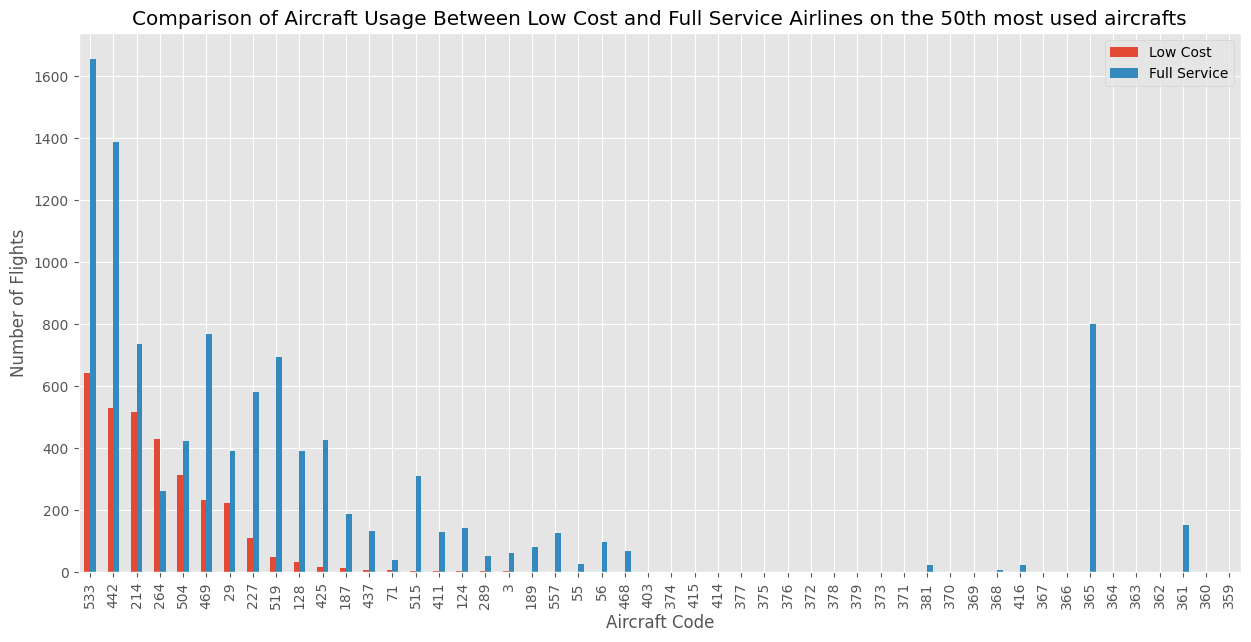

In [27]:
plt.figure(figsize=(30,12))
combined_aircraft_usage.sort_values(by="Low Cost", ascending=False).iloc[:50].plot(kind="bar", figsize=(15, 7), title="Comparison of Aircraft Usage Between Low Cost and Full Service Airlines on the 20th most used aircrafts")
plt.xlabel("Aircraft Code")
plt.ylabel("Number of Flights")
plt.title("Comparison of Aircraft Usage Between Low Cost and Full Service Airlines on the 50th most used aircrafts")
plt.legend()
plt.xticks(rotation=90)
plt.show()

- Companies low-cost qui utilise des avions long-courrier
- Y'en a que 7, contre 90 pour les companies full-services

In [28]:
long_range_code = ["B789","B788","B772","A333"]

companies_that_use_long_range = df_arrivals_low_cost[df_arrivals_low_cost["Aircraft Code"].isin(long_range_code)]["Airline Name"].unique()
companies_that_use_long_range_full_service = df_arrivals_full_service[df_arrivals_full_service["Aircraft Code"].isin(long_range_code)]["Airline Name"].unique()

print("Number of low cost airlines that use long range aircrafts : ", len(companies_that_use_long_range))
print("Number of full service airlines that use long range aircrafts : ", len(companies_that_use_long_range_full_service))

Number of low cost airlines that use long range aircrafts :  7
Number of full service airlines that use long range aircrafts :  90


- En générale les companies low-cost déservent moins d'aeroport internationaux que les companies full-service

``Aéroport de départ et deservies par companies low-cost vs full service``

- En terme de chiffre pure, les companies full-service deservent bien plus d'aeroport internationnaux que les companies low-cost
- Même constat pour les aéroport de départ

In [29]:
def preprocess(airport):
    airport = airport.lower()
    airport = airport.strip()
    return airport

In [30]:
def calculate_number_of_airport_arrivals(df):
    number_of_airport_arrivals = len(df["Airport"].unique())
    number_of_international_airport_arrivals = len(set(df["Airport"].apply(preprocess).unique()).intersection(set(df_international_airports["Airport"].apply(preprocess).unique())))
    print("On the ", number_of_airport_arrivals, " airports that low cost airlines arrive from, ", number_of_international_airport_arrivals, " are international airports")
    print(f"Ratio : {number_of_international_airport_arrivals/number_of_airport_arrivals * 100}%")

print("[ARRIVALS]")
calculate_number_of_airport_arrivals(df_arrivals_low_cost)
calculate_number_of_airport_arrivals(df_arrivals_full_service)
print()
print("[DEPARTURES]")
calculate_number_of_airport_arrivals(df_departures_low_cost)
calculate_number_of_airport_arrivals(df_departures_full_service)

[ARRIVALS]
On the  961  airports that low cost airlines arrive from,  299  are international airports
Ratio : 31.113423517169615%
On the  2089  airports that low cost airlines arrive from,  479  are international airports
Ratio : 22.929631402584967%

[DEPARTURES]
On the  821  airports that low cost airlines arrive from,  239  are international airports
Ratio : 29.11084043848965%
On the  1874  airports that low cost airlines arrive from,  438  are international airports
Ratio : 23.372465314834578%


``Destination deservies par les companies low-cost``

- Concernant les destinations, les companies low-cost deservent moins de destination que les companies fsull-service, voir la map ci-dessous
- Exemple de destination non deservie par les companies low-cost : Nigeria, Uruguay, Iran etc... 

In [31]:
def calculate_number_of_dest(df):
    all_dest = df["Destination Country"].unique()
    print(f"{len(all_dest)} unique destination")

calculate_number_of_dest(df_departures_low_cost)
calculate_number_of_dest(df_departures_full_service)

104 unique destination
183 unique destination


C:\Users\halim\AppData\Local\Temp\ipykernel_16764\361647004.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Counries not deserved by low cost companies : {'Mauritius', 'Macao', 'Rwanda', 'Mayotte', 'Lesotho', 'Bolivia', 'Seychelles', 'Panama', 'Gambia', 'Angola', 'Libya', 'Saint Lucia', 'Montenegro', 'Tanzania', 'Laos', 'Paraguay', 'Georgia', 'Palau', 'Barbados', 'Solomon Islands', 'Bermuda', 'Samoa', 'Grenada', 'Guadeloupe', 'Guyana', 'Botswana', 'Eritrea', 'Greenland', 'Mozambique', 'Sierra Leone', 'Virgin Islands British', 'Moldova', 'Uzbekistan', 'Benin', 'Bahrain', 'Nigeria', 'Saint Kitts And Nevis', 'Cocos (Keeling) Islands', 'Mali', 'Tuvalu', 'Ethiopia', 'Northern Mariana Islands', 'Dominica', 'Martinique', 'Marshall Islands', 'Curacao', 'Guam', 'Tonga', 'Pakistan', 'Democratic Republic Of The Congo', 'Saint Vincent And The Grenadines', 'Burundi', 'Ghana', 'Micronesia', 'Trinidad And Tobago', 'Suriname', 'Congo', 'Faroe Islands', 'Brazil', 'Uganda', 'Guernsey', 'Cayman Islands', 'Madagascar', 'Kyrgyzstan', 'Namibia', 'Malawi', 'Iran', 'Anguilla', 'Vanuatu', 'New Caledonia', 'American 

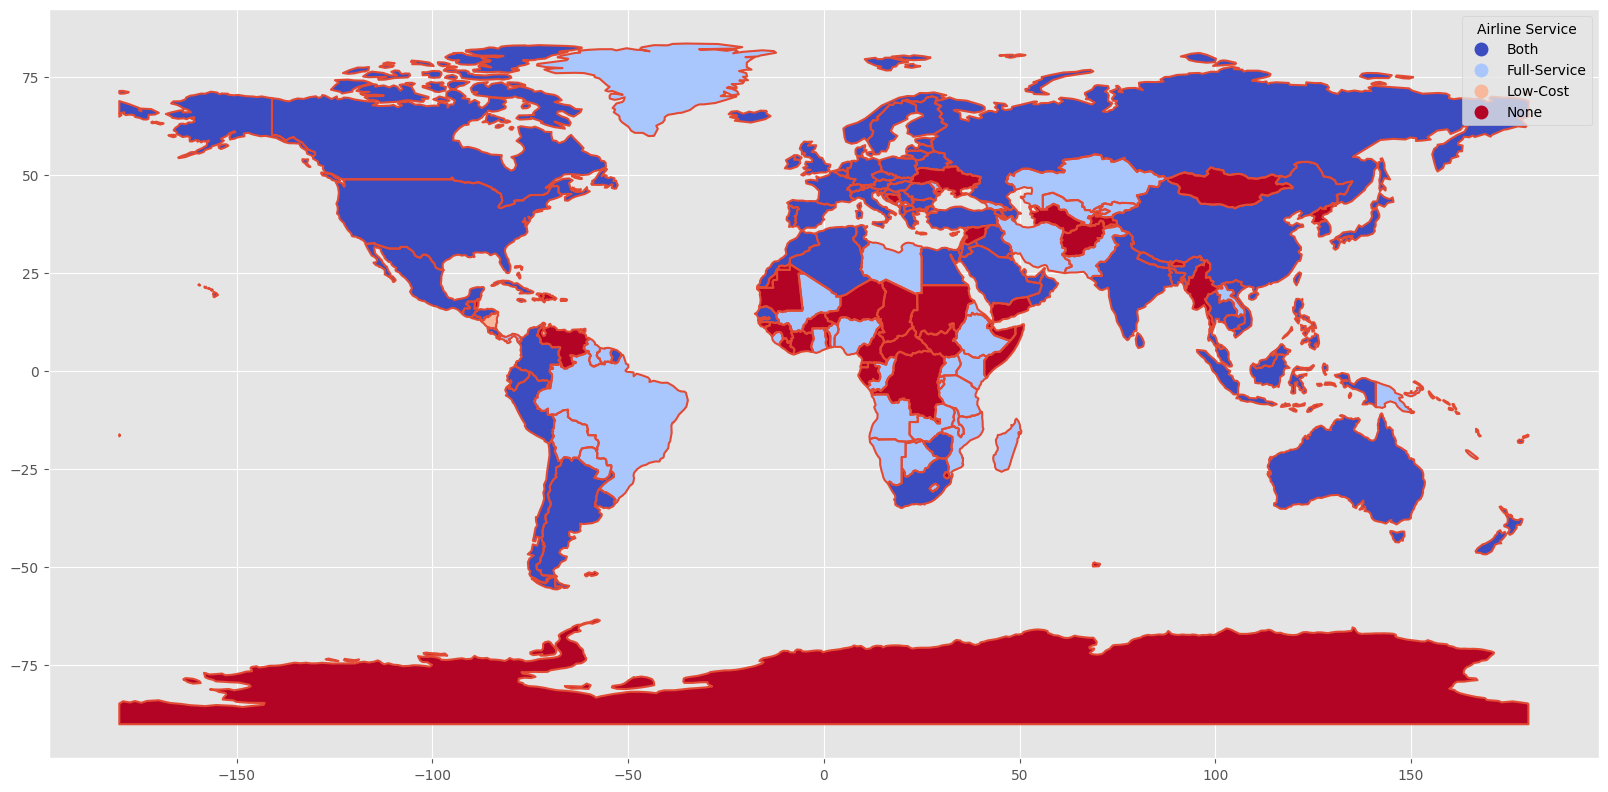

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt

def preprocess_usa(country):
    if(country == "United States"):
        return "United States of America"
    return country

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries_full_service = df_departures_full_service["Destination Country"].apply(preprocess_usa).unique()
countries_low_cost = df_departures_low_cost["Destination Country"].apply(preprocess_usa).unique()
print(f"Counries not deserved by low cost companies : {set(countries_full_service)-set(countries_low_cost)}")
# Create a new column in the world dataframe to represent the airline service
world['airline_service'] = 'None'
world.loc[world['name'].isin(countries_full_service), 'airline_service'] = 'Full-Service'
world.loc[world['name'].isin(countries_low_cost), 'airline_service'] = 'Low-Cost'

# For countries served by both, we adjust the entry accordingly
world.loc[world['name'].isin(set(countries_full_service).intersection(set(countries_low_cost))), 'airline_service'] = 'Both'

# Plottings
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
world.boundary.plot(ax=ax)
world.plot(column='airline_service', ax=ax, legend=True,
           legend_kwds={'title': 'Airline Service'},
           cmap='coolwarm')
plt.show()


``Fréquence de vol de companies low-cost vs full-service``

- On constate que les companies avec le plus de fréquence de vols, sont 2 companies low-cost: 
    - Southwest Airline, et IndiGO
- On constate clairement que la mediane, les quartiles, et la moyenne sont bien plus elevé pour les companies low-cost que full-service

In [33]:
companies_low_cost_freq = df_matched_low_cost.groupby("Airline Name").apply(len).sort_values(ascending=False)
companies_full_service_freq = df_matched_full_service.groupby("Airline Name").apply(len).sort_values(ascending=False)

companies_low_cost_freq = companies_low_cost_freq.to_frame(name='Frequency')
companies_full_service_freq = companies_full_service_freq.to_frame(name='Frequency')

companies_low_cost_freq['Airline Service'] = 'Low-Cost'
companies_full_service_freq['Airline Service'] = 'Full-Service'

all_comp_freq = pd.concat([companies_low_cost_freq, companies_full_service_freq], axis=0)
all_comp_freq = all_comp_freq.reset_index()

In [34]:
print("Top 10 companies with more frequency : ")
all_comp_freq.sort_values(by="Frequency", ascending=False).head(10)

Top 10 companies with more frequency : 


,Airline Name,Frequency,Airline Service
0,Southwest Airlines,829,Low-Cost
1,IndiGo,725,Low-Cost
55,Delta Air Lines,675,Full-Service
54,SkyWest Airlines,675,Full-Service
56,American Airlines,665,Full-Service
57,Azul Linhas Aereas,600,Full-Service
58,United Airlines,547,Full-Service
59,China Eastern Airlines,380,Full-Service
60,Air New Zealand,338,Full-Service
61,LATAM Brasil,315,Full-Service


In [35]:
pd.concat([companies_low_cost_freq.describe(), companies_full_service_freq.describe()], axis=1, keys=["Low cost", "Full service"])

,Low cost,Full service
,Frequency,Frequency
count,54.000000,589.000000
mean,58.092593,23.336163
std,148.368901,69.784891
min,1.000000,1.000000
25%,2.000000,1.000000
50%,10.500000,3.000000
75%,53.500000,15.000000
max,829.000000,675.000000


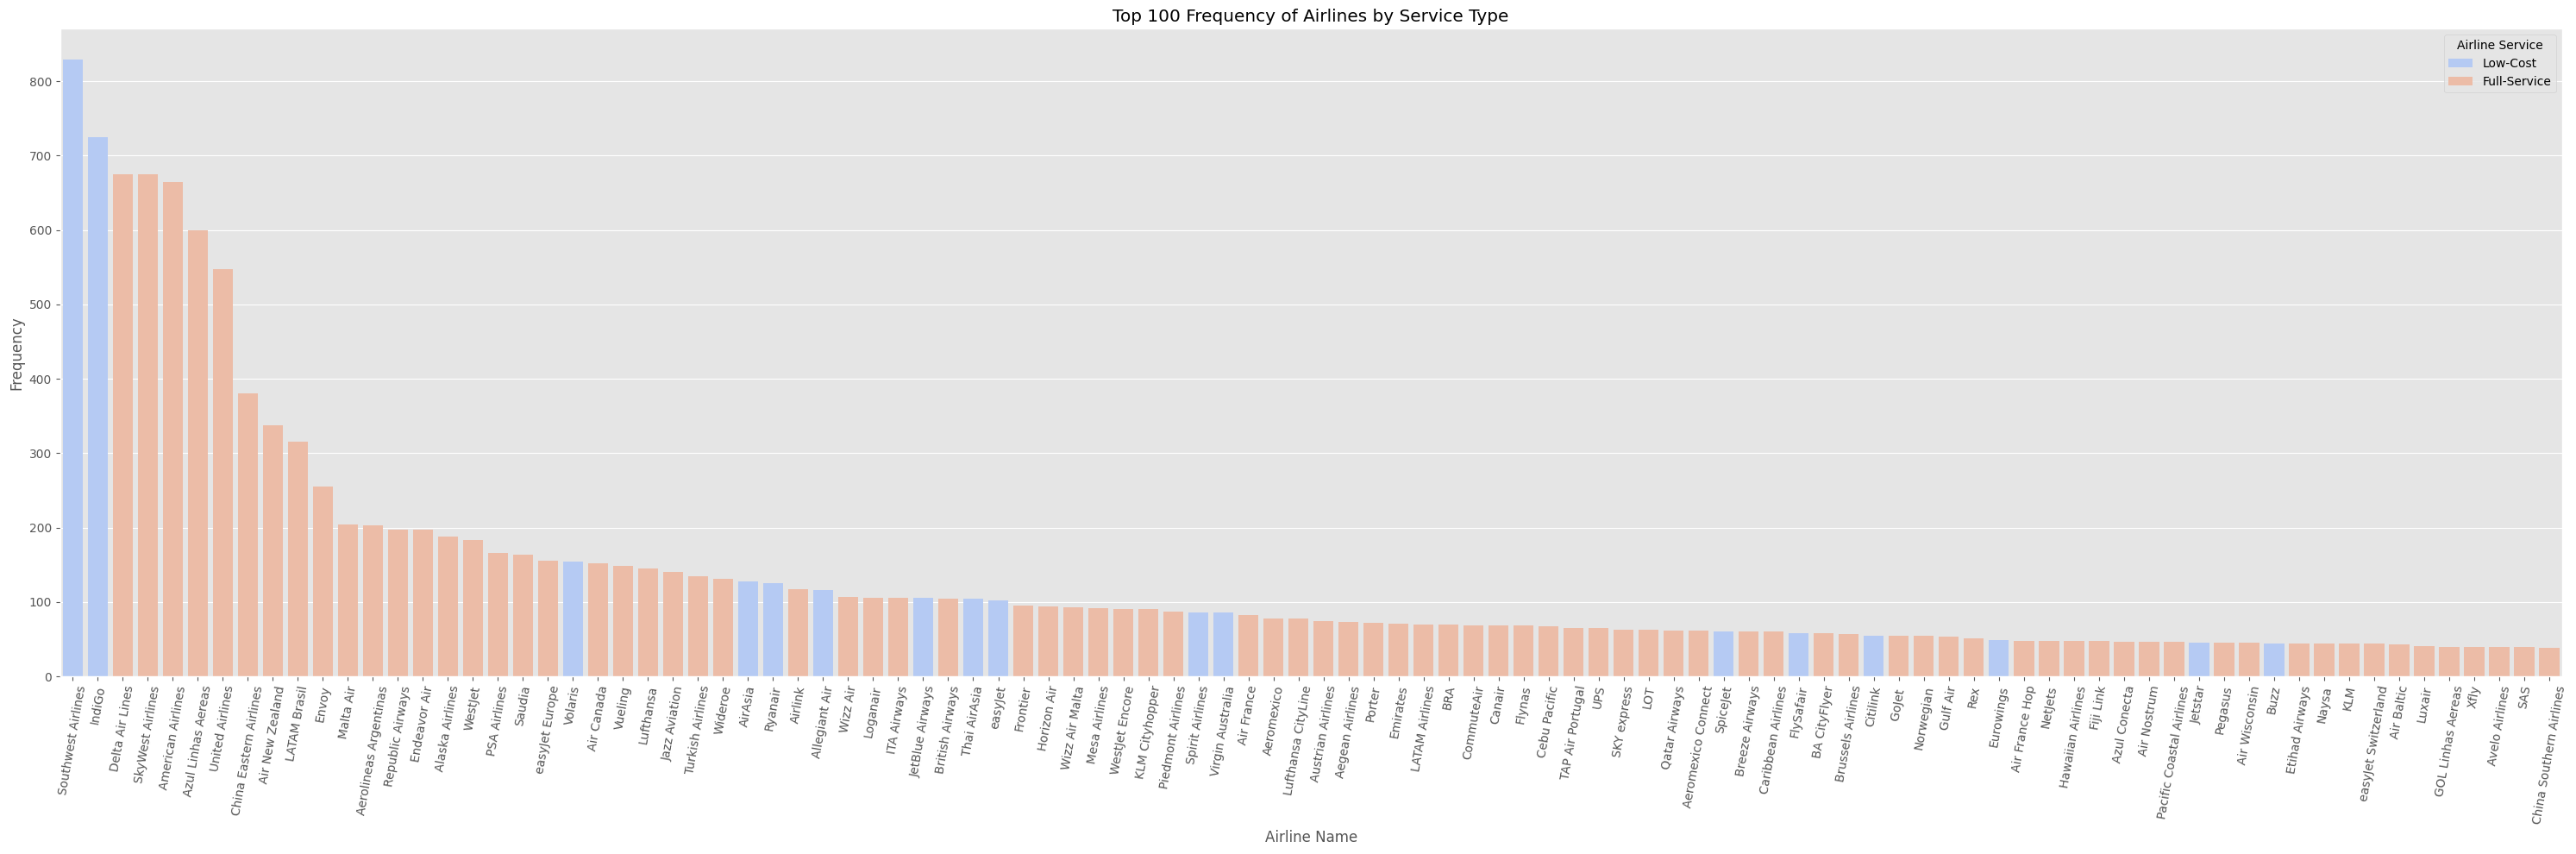

In [36]:
all_comp_freq.sort_values(by='Frequency', ascending=False, inplace=True)

plt.figure(figsize=(30, 10))
ax = sns.barplot(data=all_comp_freq.head(100), x='Airline Name', y='Frequency', hue='Airline Service', palette='coolwarm')

ax.set_title('Top 100 Frequency of Airlines by Service Type')
ax.set_xlabel('Airline Name')
ax.set_ylabel('Frequency')
plt.xticks(rotation=80) 
plt.legend(title='Airline Service')

plt.tight_layout()
plt.show()

## USA Part
- Ici nous allons nous concentrer uniquement sur les USA (2015) pour comparer les companies low-cost et full-service
- On fera les memes test, ainsi que d'autre

In [37]:
df_flights = pd.read_csv("../data/flights.csv")
print(df_flights.shape)
df_flights.head()

C:\Users\halim\AppData\Local\Temp\ipykernel_16764\3521560025.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv("../data/flights.csv")


(5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


``Cleaning step``

In [38]:
import os

if os.path.exists("../data/flights_cleaned.csv"):
    df_flights_cleaned = pd.read_csv("../data/flights_cleaned.csv")
else:
    df_flights_cleaned = df_flights.copy()
    df_flights_cleaned.insert(loc = 0, column = 'DATE',value = pd.to_datetime(df_flights.loc[:, ['YEAR','MONTH', 'DAY']]))
    import datetime
    import numpy as np
    #Fonction qui convertit ce format en un format datetime.time
    def convert_time(chaine):
        float(chaine.iloc[0])
        if pd.isna(chaine.iloc[0]):
            return np.nan
        else:
            if chaine.iloc[0] == 2400: 
                chaine.iloc[0] = 0
            chaine = "{0:04d}".format(int(chaine.iloc[0]))
            heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
            return heure

    def format_col(df,col):
        liste = []
        for index,value in df[[col]].iterrows():
            liste.append(convert_time(value))
        return liste


    #Convertir les heures au bon format
    df_flights_cleaned.loc[:,'SCHEDULED_DEPARTURE']= format_col(df_flights_cleaned, 'SCHEDULED_DEPARTURE')
    df_flights_cleaned.loc[:,'DEPARTURE_TIME'] = format_col(df_flights_cleaned, 'DEPARTURE_TIME')
    df_flights_cleaned.loc[:,'SCHEDULED_ARRIVAL'] = format_col(df_flights_cleaned, 'SCHEDULED_ARRIVAL')
    df_flights_cleaned.loc[:,'ARRIVAL_TIME'] = format_col(df_flights_cleaned, 'ARRIVAL_TIME')

    #Convertir les distances de miles à kilomètres
    import math
    def miles_to_kilometers(miles):
        return math.ceil(float(miles.iloc[0]) * 1.60934)

    def convert_distances(df,col):
        liste = []
        for index,value in df[[col]].iterrows():
            liste.append(miles_to_kilometers(value))
        return liste

    df_flights_cleaned.loc[:,'DISTANCE']= convert_distances(df_flights_cleaned, 'DISTANCE')
    df_flights_cleaned.to_csv("../data/flights_cleaned.csv", index=False)

C:\Users\halim\AppData\Local\Temp\ipykernel_16764\392051206.py:4: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights_cleaned = pd.read_csv("../data/flights_cleaned.csv")


In [39]:
non_used_columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK','FLIGHT_NUMBER', 'TAIL_NUMBER','TAXI_OUT',
       'WHEELS_OFF','WHEELS_ON', 'TAXI_IN','AIR_TIME','DIVERTED', 'CANCELLED', 'CANCELLATION_REASON','AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
       'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_flights_cleaned = df_flights_cleaned.drop(non_used_columns,axis=1)
df_flights_cleaned.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015-01-01,AS,ANC,SEA,00:05:00,23:54:00,-11.0,205.0,194.0,2331,04:30:00,04:08:00,-22.0
1,2015-01-01,AA,LAX,PBI,00:10:00,00:02:00,-8.0,280.0,279.0,3750,07:50:00,07:41:00,-9.0
2,2015-01-01,US,SFO,CLT,00:20:00,00:18:00,-2.0,286.0,293.0,3696,08:06:00,08:11:00,5.0
3,2015-01-01,AA,LAX,MIA,00:20:00,00:15:00,-5.0,285.0,281.0,3770,08:05:00,07:56:00,-9.0
4,2015-01-01,AS,SEA,ANC,00:25:00,00:24:00,-1.0,235.0,215.0,2331,03:20:00,02:59:00,-21.0


In [40]:
def is_low_cost(airline):
    for low_cost in low_cost_airlines["Low Cost Airlines"].values:
        if low_cost in airline:
            return True
    return False

all_usa_airlines = pd.read_csv("data/USA/airlines.csv")
all_usa_airports = pd.read_csv("data/USA/airports.csv")

low_cost_airlines = pd.read_csv("../data/Low_Cost_Airlines.csv")

us_low_cost = all_usa_airlines[all_usa_airlines["AIRLINE"].apply(is_low_cost)]
us_full_serivce = all_usa_airlines[~all_usa_airlines["AIRLINE"].apply(is_low_cost)]

In [41]:
df_flights_cleaned.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015-01-01,AS,ANC,SEA,00:05:00,23:54:00,-11.0,205.0,194.0,2331,04:30:00,04:08:00,-22.0
1,2015-01-01,AA,LAX,PBI,00:10:00,00:02:00,-8.0,280.0,279.0,3750,07:50:00,07:41:00,-9.0
2,2015-01-01,US,SFO,CLT,00:20:00,00:18:00,-2.0,286.0,293.0,3696,08:06:00,08:11:00,5.0
3,2015-01-01,AA,LAX,MIA,00:20:00,00:15:00,-5.0,285.0,281.0,3770,08:05:00,07:56:00,-9.0
4,2015-01-01,AS,SEA,ANC,00:25:00,00:24:00,-1.0,235.0,215.0,2331,03:20:00,02:59:00,-21.0


``Number of low cost flights vs full service``
- On constate que on a 2.46x plus de vol full service que de low-cost

In [42]:
df_flights_cleaned.insert(loc = 0, column = "AIRLINE_NAME", value = df_flights_cleaned["AIRLINE"].map(all_usa_airlines.set_index("IATA_CODE")["AIRLINE"]))
df_flights_cleaned.insert(loc = 1, column = "AIRLINE_SERVICE", value = df_flights_cleaned["AIRLINE_NAME"].apply(lambda x: "Low Cost" if x in us_low_cost["AIRLINE"].values else "Full Service"))

In [43]:
df_flights_low_cost = df_flights_cleaned[df_flights_cleaned["AIRLINE_SERVICE"]=="Low Cost"]
df_flights_full_service = df_flights_cleaned[df_flights_cleaned["AIRLINE_SERVICE"]=="Full Service"]

There is 1681642 low cost flights and 4137437 full service flights


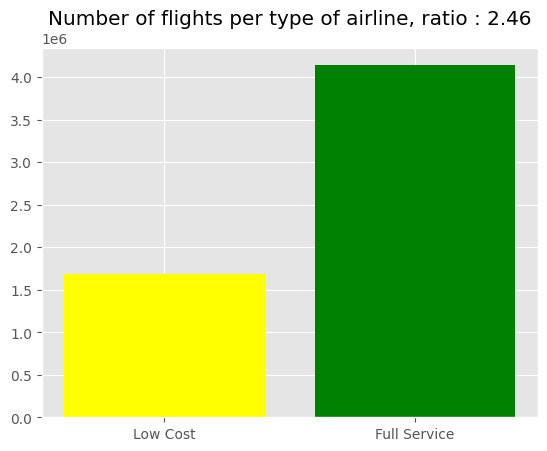

In [44]:
nb_low_cost = df_flights_low_cost.shape[0]
nb_full_service = df_flights_full_service.shape[0]

print(f"There is {df_flights_low_cost.shape[0]} low cost flights and {df_flights_full_service.shape[0]} full service flights")

plt.figure()
plt.bar(["Low Cost", "Full Service"], [nb_low_cost, nb_full_service], color=["yellow", "green"])
plt.title(f"Number of flights per type of airline, ratio : {nb_full_service / nb_low_cost:.2f}")    
plt.show()

``Comparaison en terme de retard et de distance parcouru``
- On constate que en moyenne les companies low cost font plus de retard que les companes full service, est ce que c'est significativement vrai ?
- Que en moyenne les companies low cost parcours plus de distance malgrès le fait que y'en ai 2.46x moins 

In [45]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_flights_cleaned.groupby("AIRLINE_SERVICE")[['DEPARTURE_DELAY', 'DISTANCE']].describe()

DEPARTURE_DELAY                                             \
                          count   mean    std     min    25%    50%    75%   
AIRLINE_SERVICE                                                              
Full Service        4072279.000  8.778 38.460 -82.000 -5.000 -2.000  6.000   
Low Cost            1660647.000 10.822 33.415 -46.000 -4.000  0.000 11.000   

                            DISTANCE                                    \
                     max       count     mean      std     min     25%   
AIRLINE_SERVICE                                                          
Full Service    1988.000 4137437.000 1319.934 1019.222  34.000 575.000   
Low Cost        1112.000 1681642.000 1333.820  868.703 110.000 646.000   

                                            
                     50%      75%      max  
AIRLINE_SERVICE                             
Full Service    1018.000 1698.000 8020.000  
Low Cost        1121.000 1718.000 4352.000

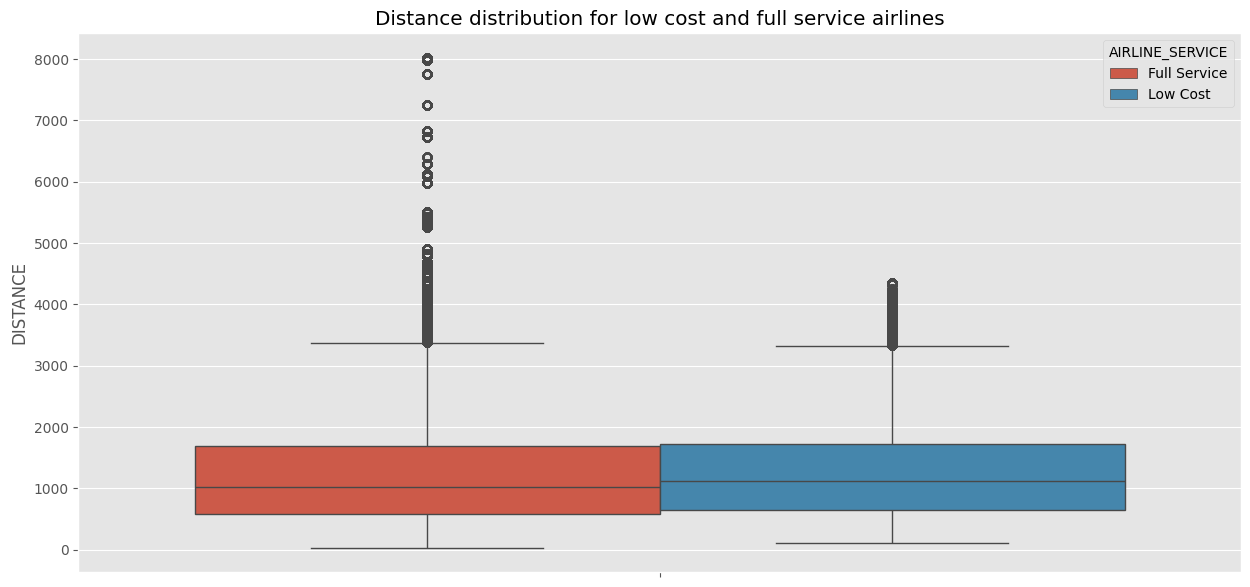

In [46]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_flights_cleaned.groupby("AIRLINE_SERVICE")[['DEPARTURE_DELAY', 'DISTANCE']].describe()
plt.figure(figsize=(15, 7))
plt.title("Distance distribution for low cost and full service airlines")
sns.boxplot(
    data=df_flights_cleaned,
    y="DISTANCE",
    hue="AIRLINE_SERVICE",
)
plt.show()

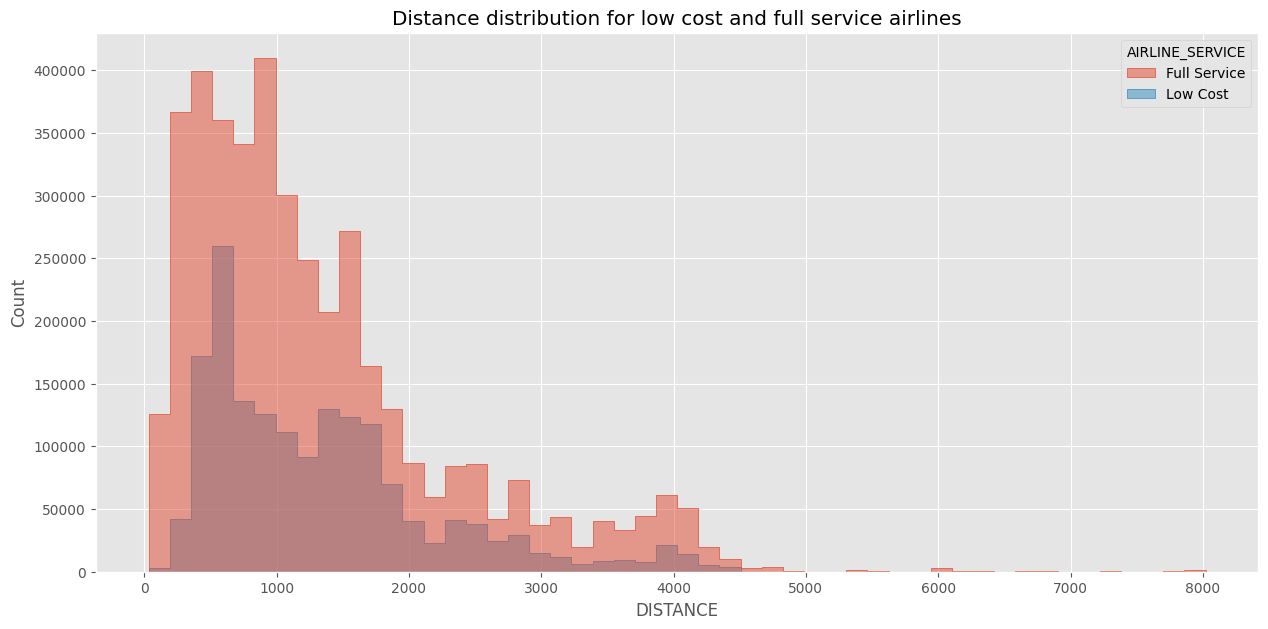

In [47]:
plt.figure(figsize=(15, 7))
sns.histplot(
    data=df_flights_cleaned,
    x="DISTANCE",
    hue="AIRLINE_SERVICE",
    bins=50,
    alpha=0.5,
    element="step"  # You can use "bars", "step", "poly" depending on your preference
)

plt.title("Distance distribution for low cost and full service airlines")
plt.show()

In [48]:
companies_low_cost_freq_usa = df_flights_low_cost.groupby("AIRLINE_NAME").apply(len).sort_values(ascending=False)
companies_full_service_freq_usa = df_flights_full_service.groupby("AIRLINE_NAME").apply(len).sort_values(ascending=False)

companies_low_cost_freq_usa = companies_low_cost_freq_usa.to_frame(name='Frequency')
companies_full_service_freq_usa = companies_full_service_freq_usa.to_frame(name='Frequency')

companies_low_cost_freq_usa['Airline Service'] = 'Low-Cost'
companies_full_service_freq_usa['Airline Service'] = 'Full-Service'

all_comp_freq_usa = pd.concat([companies_low_cost_freq_usa, companies_full_service_freq_usa], axis=0)
all_comp_freq_usa = all_comp_freq_usa.reset_index()

- On constate clairement que la companies avec le plus de fréquence de vol est une companie low-cost, plus de 1261855 vol en 2015

In [49]:
all_comp_freq_usa.sort_values(by='Frequency', ascending=False, inplace=True)
all_comp_freq_usa.head(3)

,AIRLINE_NAME,Frequency,Airline Service
0,Southwest Airlines Co.,1261855,Low-Cost
4,Delta Air Lines Inc.,875881,Full-Service
5,American Airlines Inc.,725984,Full-Service


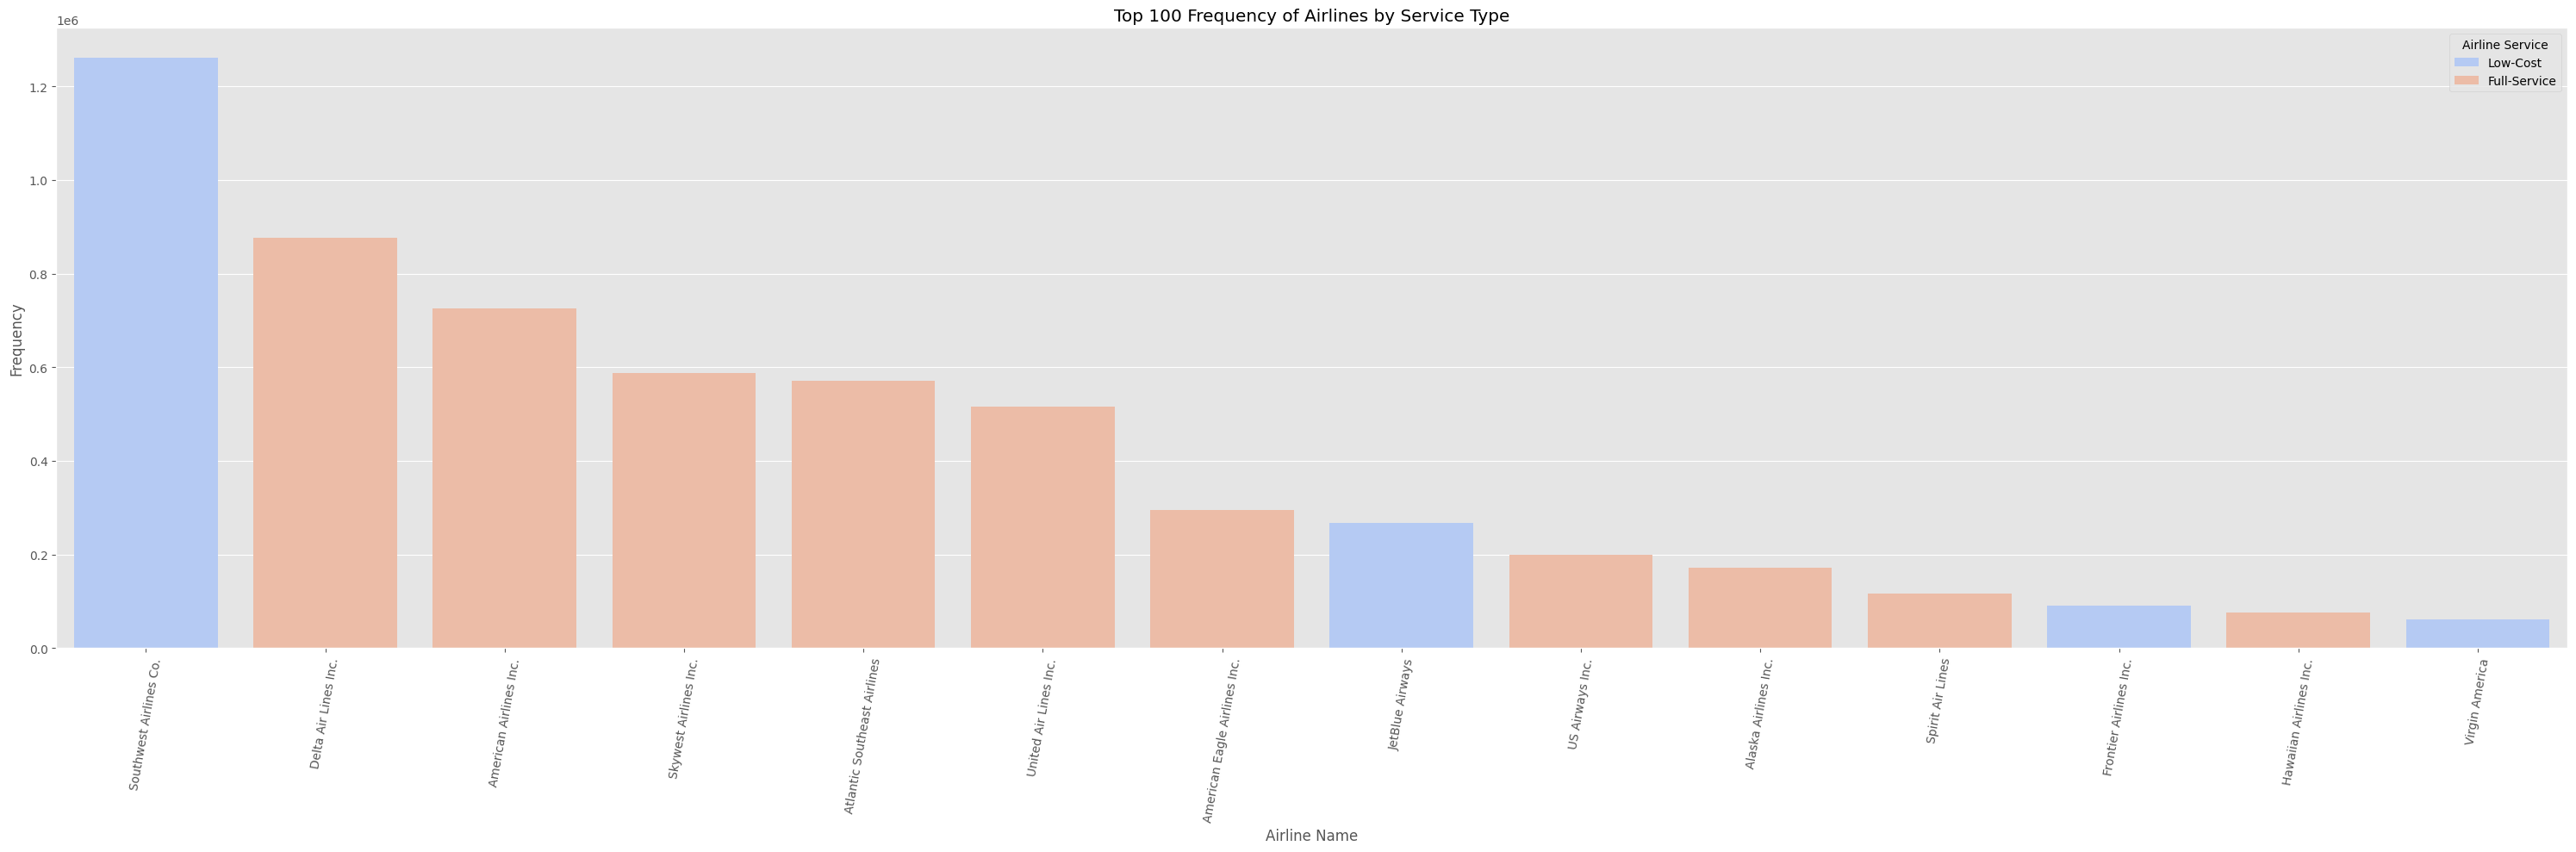

In [50]:
plt.figure(figsize=(30, 10))
ax = sns.barplot(data=all_comp_freq_usa, x='AIRLINE_NAME', y='Frequency', hue='Airline Service', palette='coolwarm')

ax.set_title('Top 100 Frequency of Airlines by Service Type')
ax.set_xlabel('Airline Name')
ax.set_ylabel('Frequency')
plt.xticks(rotation=80) 
plt.legend(title='Airline Service')

plt.tight_layout()
plt.show()

- On constate que les companies full-service deservent bien plus de destination que les companies low-cost

C:\Users\halim\AppData\Local\Temp\ipykernel_16764\2601888457.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Counries not deserved by low cost companies : {'Taiwan', 'Singapore', 'Australia', 'Cayman Islands', 'New Zealand', 'Turkey', 'Netherlands', 'Portugal', 'Chile', 'Vietnam', 'Poland', 'Greece', 'Guam', 'Finland', 'Antigua And Barbuda', 'India', 'Anguilla', 'Denmark', 'Germany', 'South Korea', 'Bolivia', 'Peru', 'Virgin Islands British', 'Panama', 'Qatar', 'Philippines', 'American Samoa', 'Japan', 'Azerbaijan', 'Ireland', 'Switzerland', 'Ghana', 'United Arab Emirates', 'Senegal', 'Italy', 'Belgium', 'Bermuda', 'Nigeria', 'Trinidad And Tobago', 'Fiji', 'South Africa', 'Virgin Islands Us', 'Brazil', 'Hong Kong', 'Argentina', 'Guyana'}


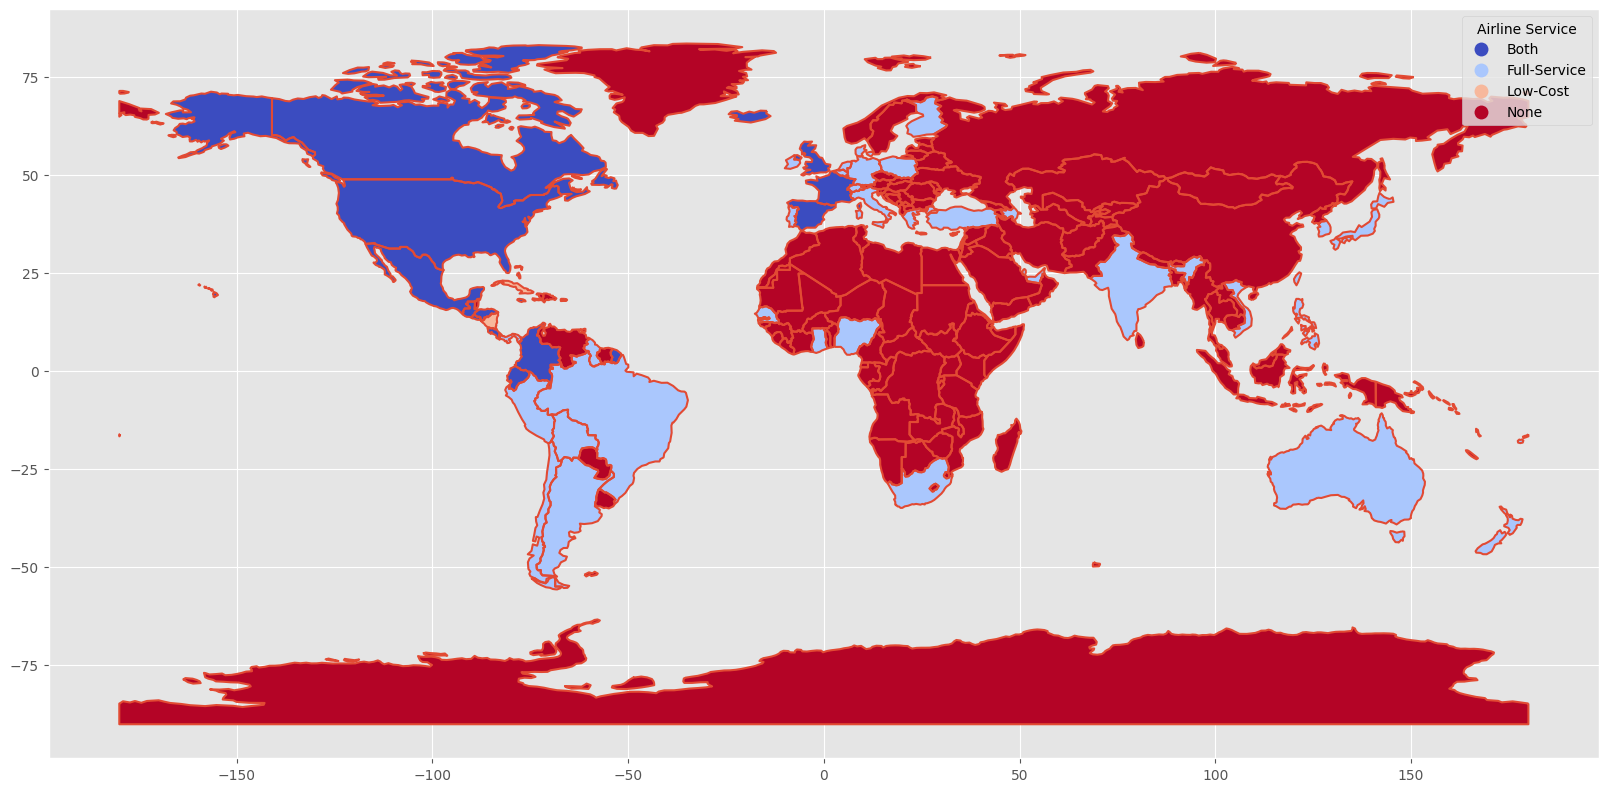

In [51]:
import geopandas as gpd
import matplotlib.pyplot as plt

def preprocess_usa(country):
    if(country == "United States"):
        return "United States of America"
    return country

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries_full_service = df_departures_full_service[df_departures_full_service["Country"]=="United States"]["Destination Country"].apply(preprocess_usa).unique()
countries_low_cost = df_departures_low_cost[df_departures_low_cost["Country"]=="United States"]["Destination Country"].apply(preprocess_usa).unique()
print(f"Counries not deserved by low cost companies : {set(countries_full_service)-set(countries_low_cost)}")
# Create a new column in the world dataframe to represent the airline service
world['airline_service'] = 'None'
world.loc[world['name'].isin(countries_full_service), 'airline_service'] = 'Full-Service'
world.loc[world['name'].isin(countries_low_cost), 'airline_service'] = 'Low-Cost'

# For countries served by both, we adjust the entry accordingly
world.loc[world['name'].isin(set(countries_full_service).intersection(set(countries_low_cost))), 'airline_service'] = 'Both'

# Plottings
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
world.boundary.plot(ax=ax)
world.plot(column='airline_service', ax=ax, legend=True,
           legend_kwds={'title': 'Airline Service'},
           cmap='coolwarm')
plt.show()


``ANOVA TEST ONE WAY``

- Test de bartlett pour voir si les variances sont homogènes dans les deux groupes
- Résultat, ce n'est pas le cas 

In [52]:
df_flights_low_cost["DEPARTURE_DELAY"].var(), df_flights_full_service["DEPARTURE_DELAY"].var()

(1116.5792405257134, 1479.166413165223)

In [53]:
from scipy.stats import bartlett

bartlett_delay = bartlett(df_flights_low_cost["DEPARTURE_DELAY"], df_flights_full_service["DEPARTURE_DELAY"])

print(f"Result for delay : {bartlett_delay}")

Result for delay : BartlettResult(statistic=45343.751363126066, pvalue=0.0)


- Test de shapiro pour verifier que les residues suivent une loi normale
- Résulat : c'est le cas pour les delays

In [54]:
def check_if_ok(shapiro_test,type="test"):
    print(f"P-VALUE is : {shapiro_test.pvalue}")
    THRESHOLD = 0.01
    if shapiro_test.pvalue < THRESHOLD:
        print(f"Les {type} ne suivent pas une loi normale")
    else:
        print(f"Les {type} suivent une loi normale")

In [55]:
from scipy.stats import shapiro
from statsmodels.formula.api import ols


def compare_ols_by(column_name="DEPARTURE_DELAY"):
    print(f"====================== COMPARING BY {column_name}")
    moore_lm = ols(f'{column_name} ~ AIRLINE_SERVICE', data=df_flights_cleaned).fit() 
    var_resid = moore_lm.resid

    shapiro_test_residue = shapiro(var_resid)
    shapiro_test_delay = shapiro(df_flights_cleaned[column_name])

    check_if_ok(shapiro_test_residue,"residus")
    check_if_ok(shapiro_test_delay,column_name.lower())
    print("")

compare_ols_by("DEPARTURE_DELAY")

====================== COMPARING BY DEPARTURE_DELAY


c:\Users\halim\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


P-VALUE is : 0.0
Les residus ne suivent pas une loi normale
P-VALUE is : 1.0
Les departure_delay suivent une loi normale



- Test d'ANOVA et WELCH annova
- Vu que nos données suivent une loi normale, mais elle ne respecte pas l'homogéinité des variance, nous allons appliqué le test de : 
``Welch's Anova``

In [56]:
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols

def compare_anova_by(column_name, welch=False):
    print(f"====================== COMPARING BY {column_name}")
    anova_results = None
    if welch :
        anova_results = pg.welch_anova(data=df_flights_cleaned, dv=column_name, between='AIRLINE_SERVICE')
    else:
        moore_lm = ols('DEPARTURE_DELAY ~ AIRLINE_SERVICE', data=df_flights_cleaned).fit() 
        anova_results = sm.stats.anova_lm(moore_lm, typ=2) 
    print(anova_results)
    print("")

compare_anova_by("DEPARTURE_DELAY", welch=True)

====================== COMPARING BY DEPARTURE_DELAY
            Source  ddof1       ddof2        F  p-unc   np2
0  AIRLINE_SERVICE      1 3520523.364 4036.439  0.000 0.001



- Application du test de Games Howell vu que les variances ne sont pas homogène
- Résultat, la pval est de 0, donc il y'a bien une différence significative entre les deux groupes

In [57]:
from statsmodels.sandbox.stats.multicomp import MultiComparison

def compare_by(column_name="DEPARTURE_DELAY", welch=True):
    print(f"====================== COMPARING BY {column_name}")
    result = None
    if welch : 
        result = pg.pairwise_gameshowell(data=df_flights_cleaned, dv=column_name, between='AIRLINE_SERVICE')
        print(result)
    else:
        mc = MultiComparison(df_flights_cleaned[column_name], df_flights_cleaned['AIRLINE_SERVICE'])
        result = mc.tukeyhsd(alpha=0.05)
    print(result)
    print("")

compare_by("DEPARTURE_DELAY", welch=True)

====================== COMPARING BY DEPARTURE_DELAY
              A         B  mean(A)  mean(B)   diff    se       T          df  \
0  Full Service  Low Cost    8.778   10.822 -2.045 0.032 -63.533 3520523.364   

   pval  hedges  
0 0.000  -0.055  
              A         B  mean(A)  mean(B)   diff    se       T          df  \
0  Full Service  Low Cost    8.778   10.822 -2.045 0.032 -63.533 3520523.364   

   pval  hedges  
0 0.000  -0.055  

